In [1]:
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA, LatentDirichletAllocation, NMF, FactorAnalysis
from sklearn.cluster import KMeans, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.covariance import GraphicalLasso
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time

In [2]:

with open('data.pickle', 'rb') as handle:
    subs_train, subs_test, subs_val, hlth_train, hlth_test, hlth_val, demo_train, demo_test, demo_val = pickle.load(handle)

subs_train_o = subs_train.drop(['QUESTID2', 'FILEDATE'], axis=1)
subs_test_o = subs_test.drop(['QUESTID2', 'FILEDATE'], axis=1)
subs_val_o = subs_val.drop(['QUESTID2', 'FILEDATE'], axis=1)

In [3]:
with open('data_removed_updated.pickle', 'rb') as handle:
    all_train, all_test, subs_train, subs_test, subs_val, hlth_train, hlth_test, hlth_val, demo_train, demo_test, demo_val = pickle.load(handle)

all_train = pd.concat([subs_train_o, hlth_train, demo_train], axis=1)
all_test = pd.concat([subs_test_o, hlth_test, demo_test], axis=1)
all_val = pd.concat([subs_val_o, hlth_val, demo_val], axis=1)

all_test = pd.concat([all_test, all_val], axis=0)

In [4]:
# Remove features with greater than 10 unique values
for feature in all_train.keys():
    if all_train[feature].nunique() > 10:
        all_train = all_train.drop([feature], axis=1)
        all_test = all_test.drop([feature], axis=1)

for feature in subs_train_o.keys():
    if subs_train_o[feature].nunique() > 10:
        subs_train_o = subs_train_o.drop([feature], axis=1)
        subs_test_o = subs_test_o.drop([feature], axis=1)

for feature in hlth_train.keys():
    if hlth_train[feature].nunique() > 10:
        hlth_train = hlth_train.drop([feature], axis=1)
        hlth_test = hlth_test.drop([feature], axis=1)

for feature in demo_train.keys():
    if demo_train[feature].nunique() > 10:
        demo_train = demo_train.drop([feature], axis=1)
        demo_test = demo_test.drop([feature], axis=1)

profile_train = pd.get_dummies(all_train, columns=all_train.columns)
profile_test = pd.get_dummies(all_test, columns=all_train.columns)

# Remove features that are not present in both train and test sets
common = np.intersect1d(profile_train.columns, profile_test.columns)
profile_train = profile_train[common]
profile_test = profile_test[common]

# Get dummies for each dataset because they are categorical and KMeans requires numerical input
profile_subs = pd.get_dummies(subs_train_o, columns=subs_train_o.columns)
profile_subs_test = pd.get_dummies(subs_test_o, columns=subs_train_o.columns)
profile_hlth = pd.get_dummies(hlth_train, columns=hlth_train.columns)
profile_hlth_test = pd.get_dummies(hlth_test, columns=hlth_train.columns)
profile_demo = pd.get_dummies(demo_train, columns=demo_train.columns)
profile_demo_test = pd.get_dummies(demo_test, columns=demo_train.columns)

# Remove features that are not present in both train and test sets
common = np.intersect1d(profile_subs.columns, profile_subs_test.columns)
profile_subs = profile_subs[common]
profile_subs_test = profile_subs_test[common]
common = np.intersect1d(profile_hlth.columns, profile_hlth_test.columns)
profile_hlth = profile_hlth[common]
profile_hlth_test = profile_hlth_test[common]
common = np.intersect1d(profile_demo.columns, profile_demo_test.columns)
profile_demo = profile_demo[common]
profile_demo_test = profile_demo_test[common]

profile_subs_demo = pd.concat([profile_subs, profile_demo], axis=1)
profile_subs_hlth = pd.concat([profile_subs, profile_hlth], axis=1)

print(f"all_train: Before: {all_train.shape}     After: {profile_train.shape}")
print(f"all_test: Before: {all_test.shape}     After: {profile_test.shape}")
print(f"subs_train_o: Before: {subs_train_o.shape}     After: {profile_subs.shape}")
print(f"hlth_train: Before: {hlth_train.shape}     After: {profile_hlth.shape}")
print(f"demo_train: Before: {demo_train.shape}     After: {profile_demo.shape}")
print(f"subs_demo: {str(profile_subs_demo.shape)}")
print(f"subs_hlth: {str(profile_subs_hlth.shape)}")


all_train: Before: (45020, 527)     After: (45020, 2151)
all_test: Before: (11256, 527)     After: (11256, 2151)
subs_train_o: Before: (45020, 176)     After: (45020, 1012)
hlth_train: Before: (45020, 261)     After: (45020, 749)
demo_train: Before: (45020, 90)     After: (45020, 288)
subs_demo: (45020, 1300)
subs_hlth: (45020, 1761)


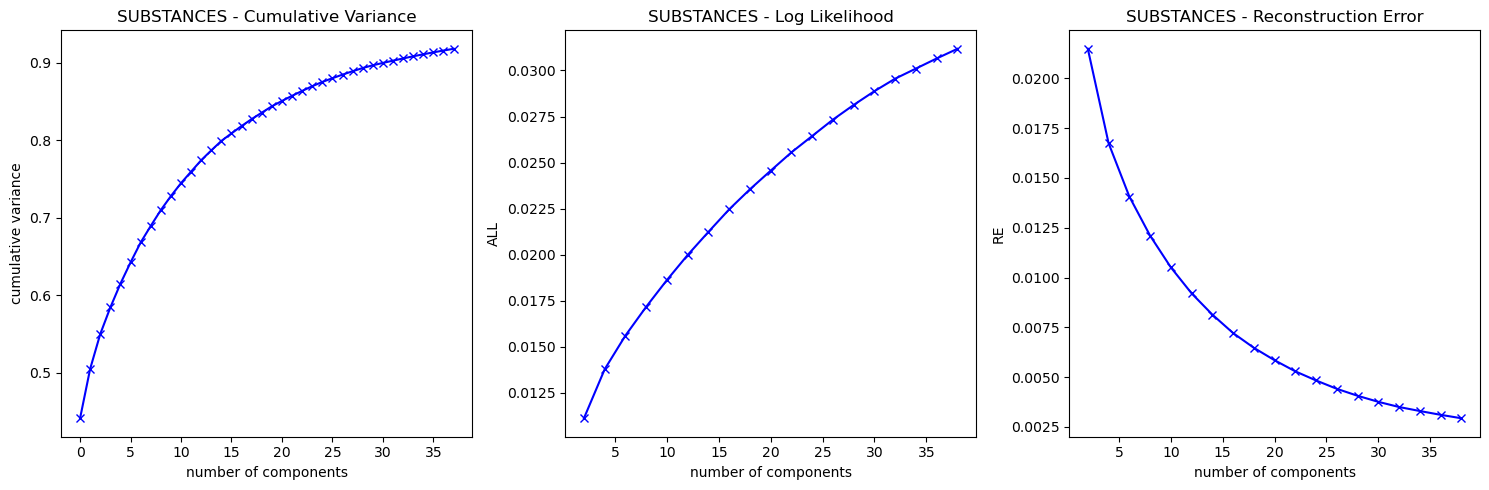

KeyboardInterrupt: 

<Figure size 1500x500 with 0 Axes>

In [5]:
train = profile_train
test = profile_test

# ----------- PCA parameter tuning -----------
'''
fig = plt.figure(figsize=(14, 10))
hrange = np.arange(2, 40, 2)
LL = np.zeros(len(hrange))
RE = np.zeros(len(hrange))
for idx in range(len(hrange)):
    model = PCA(n_components=hrange[idx])
    model.fit(train.values)
    train_transformed = model.transform(train.values)
    LL[idx] = model.score(train.values) / train.shape[0]
    train_origin = model.inverse_transform(train_transformed)
    RE[idx] = ((train.values - train_origin) ** 2).mean()

ax1 = fig.add_subplot(2, 3, 1)
pca = PCA().fit(train.values)
ax1.plot(np.cumsum(pca.explained_variance_ratio_)[2:40], 'bx-')
ax1.set_xlabel('number of components')
ax1.set_ylabel('cumulative variance', fontsize=9)

ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(hrange, LL, 'bx-', label="LL")
ax2.set_xlabel('The number of components')
ax2.set_ylabel('LL', fontsize=9)

ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(hrange, RE, 'bx-', label="RE")
ax3.set_xlabel('The number of components')
ax3.set_ylabel('RE', fontsize=9)
'''

def analyze_pca_metrics(data, name, hrange=np.arange(2, 40, 2)):
    LL = np.zeros(len(hrange))
    RE = np.zeros(len(hrange))
    
    fig = plt.figure(figsize=(15, 5))
    
    # Calculate LL and RE for different components
    for idx in range(len(hrange)):
        model = PCA(n_components=hrange[idx])
        model.fit(data.values)
        data_transformed = model.transform(data.values)
        LL[idx] = model.score(data.values) / data.shape[0]
        data_origin = model.inverse_transform(data_transformed)
        RE[idx] = ((data.values - data_origin) ** 2).mean()

    # Plot results
    ax1 = fig.add_subplot(1, 3, 1)
    pca = PCA().fit(data.values)
    ax1.plot(np.cumsum(pca.explained_variance_ratio_)[2:40], 'bx-')
    ax1.set_xlabel('number of components')
    ax1.set_ylabel('cumulative variance')
    ax1.set_title(f'{name} - Cumulative Variance')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.plot(hrange, LL, 'bx-', label="LL")
    ax2.set_xlabel('number of components')
    ax2.set_ylabel('ALL')
    ax2.set_title(f'{name} - Log Likelihood')

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.plot(hrange, RE, 'bx-', label="RE")
    ax3.set_xlabel('number of components')
    ax3.set_ylabel('RE')
    ax3.set_title(f'{name} - Reconstruction Error')
    
    plt.tight_layout()
    plt.show()
    
    return LL, RE

#calculate metrics for all datasets separately
subs_LL, subs_RE = analyze_pca_metrics(profile_subs, "SUBSTANCES")
hlth_LL, hlth_RE = analyze_pca_metrics(profile_hlth, "HEALTH")
demo_LL, demo_RE = analyze_pca_metrics(profile_demo, "DEMOGRAPHY")
subs_hlth_LL, subs_hlth_RE = analyze_pca_metrics(profile_subs_hlth, "SUBSTANCES_HEALTH")
subs_demo_LL, subs_demo_RE = analyze_pca_metrics(profile_subs_demo, "SUBSTANCES_DEMO")
train_LL, train_RE = analyze_pca_metrics(train, "TRAIN")

In [8]:
# Compare optimal components for each dataset using RE
hrange = np.arange(2, 40, 1)

def find_optimal_components(RE, hrange):
    differences = np.diff(RE)
    mean_diff = np.mean(np.abs(differences))
    #smallest difference gives flat part of the curve
    first_small_diff = np.where(np.abs(differences) < mean_diff)[0][0]
    return hrange[first_small_diff + 1]

print("Optimal components:")
print(f"Substance Use: {find_optimal_components(subs_RE, hrange)}")
print(f"Health: {find_optimal_components(hlth_RE, hrange)}")
print(f"Demographics: {find_optimal_components(demo_RE, hrange)}")
print(f"Substances_Health: {find_optimal_components(subs_hlth_RE, hrange)}")
print(f"Substances_Demographics: {find_optimal_components(subs_demo_RE, hrange)}")
print(f"Combined: {find_optimal_components(train_RE, hrange)}")


Optimal components:
Substance Use: 9
Health: 9
Demographics: 9
Substances_Health: 9
Substances_Demographics: 8
Combined: 8


/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

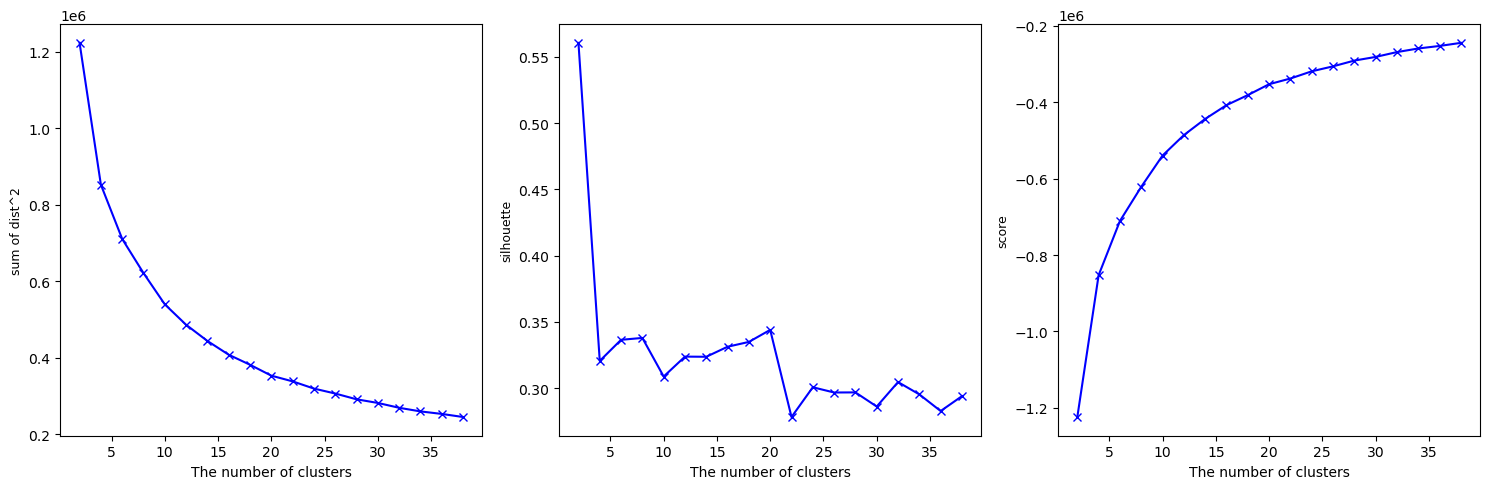

In [9]:
# ----------- K-mean parameter tuning -----------
model = PCA(n_components=8)
model.fit(train.values)
train_transformed = model.transform(train.values)

Sum_of_squared_distances = []
silhouette_avg = []
score = []
K = range(2, 40, 2)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(train_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    cluster_labels = km.predict(train_transformed)
    silhouette_avg.append(silhouette_score(train_transformed, cluster_labels))
    score.append(km.score(train_transformed))

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(K, Sum_of_squared_distances, 'bx-')
ax1.set_xlabel('The number of clusters')
ax1.set_ylabel('sum of dist^2', fontsize=9)

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(K, silhouette_avg, 'bx-')
ax2.set_xlabel('The number of clusters')
ax2.set_ylabel('silhouette', fontsize=9)

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(K, score, 'bx-')
ax3.set_xlabel('The number of clusters')
ax3.set_ylabel('score', fontsize=9)

fig.tight_layout()
out_data = "./FA_Kmeans_param.png"
fig.savefig(out_data)


 ----------GRAPH GENERATION DRUG----------
(45020, 1012)


/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



 -----USER 0-----
[104 111 134 251 254 260 262 285 412 435 477]

 -----USER 1-----
[ 51  56  64  71  79 100 108 112 130]

 -----USER 2-----
[]

 -----USER 3-----
[]

 -----USER 4-----
[709 713 723 725 732 742 755 769 784 803 835]

 -----USER 5-----
[  4  27 487 489 493 494 516 864 868 900]

 -----USER 6-----
[  5  15  23 488 497 519 864 868 876 888 917]

 -----USER 7-----
[ 57  65  72  80 487 494 516]
Train - Log-likelihood:  773.1774637610055
Train - Average Log-Likelihood:  0.017174088488694034
Train - Reconstruction Error:  0.012101804502343522
Train - Average Log-Likelihood with Kmeans:  -5.556312086860633
Train - sum of squared distance:  250145.17015046568
Train - silhouette:  0.43279454083891544
1
Train - silhouette:  0.43421499022459087
2
Train - silhouette:  0.436135263587735

 ----------GRAPH GENERATION HEALTH----------
(45020, 749)


/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



 -----USER 0-----
[168 683 689 691 719 728 736]

 -----USER 1-----
[  0   2   4   6  14  49 157 410]

 -----USER 2-----
[ 82  84  92  94 180 184 215 261]

 -----USER 3-----
[ 49 116 146 156 209 211 213 311]

 -----USER 4-----
[116 146 156 199 205 208 210 212]

 -----USER 5-----
[ 24  26  41  44  75 254 339 341]

 -----USER 6-----
[172 209 218 230 244 249 254 485]

 -----USER 7-----
[ 17  18 218 230 240 249 254 371]
Train - Log-likelihood:  204.5010855100224
Train - Average Log-Likelihood:  0.004542449700355895
Train - Reconstruction Error:  0.03213993721088451
Train - Average Log-Likelihood with Kmeans:  -3.4922936439150885
Train - sum of squared distance:  157223.0598490573
Train - silhouette:  0.3445566997778788
1
Train - silhouette:  0.364939976568776
2
Train - silhouette:  0.3346041174241536

 ----------GRAPH GENERATION DEMOGRAPHY----------
(45020, 288)


/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



 -----USER 0-----
[147]

 -----USER 1-----
[]

 -----USER 2-----
[155 194 227]

 -----USER 3-----
[143 155 194]

 -----USER 4-----
[192 281 283]

 -----USER 5-----
[157 214 283]

 -----USER 6-----
[156 213]

 -----USER 7-----
[  9 135 157]
Train - Log-likelihood:  -28.548540634375136
Train - Average Log-Likelihood:  -0.0006341301784623531
Train - Reconstruction Error:  0.06350338519725719
Train - Average Log-Likelihood with Kmeans:  -4.0494334996221415
Train - sum of squared distance:  182305.4961529888
Train - silhouette:  0.3167981394236893
1
Train - silhouette:  0.36138143852674515
2
Train - silhouette:  0.356234210277209

 ----------GRAPH GENERATION SUBSTANCES_HEALTH----------
(45020, 1761)


/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



 -----USER 0-----
[1175 1180 1207 1361 1474 1677 1695 1699 1701 1703 1720 1725 1731 1738
 1740 1744 1748 1752]

 -----USER 1-----
[104 111 134 141 204 251 254 260 262 271 285 349 388 412 435 473 477 658]

 -----USER 2-----
[1012 1014 1016 1018 1026 1056 1061 1169 1351 1353 1383 1422]

 -----USER 3-----
[  5  15  23  51  56  64  71  79  85  91 100 108 112 130 413 423 431 450]

 -----USER 4-----
[  1  35 136 228 238 242 308 311 316 319 322 324 329 344 359 444 700 704]

 -----USER 5-----
[205 209 250 255 257 264 274 281 350 383 389 474 478 655 660]

 -----USER 6-----
[  49  106  488  497  519  709  713  732  742  769  863  871  903 1061
 1322 1325 1422]

 -----USER 7-----
[ 709  713  723  725  732  742  755  769  784  803 1094 1096 1104 1106
 1192 1196 1227 1273]
Train - Log-likelihood:  736.8176427476834
Train - Average Log-Likelihood:  0.01636645141598586
Train - Reconstruction Error:  0.024675117349329756
Train - Average Log-Likelihood with Kmeans:  -8.743857334444181
Train - sum of s

/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



 -----USER 0-----
[   4    9   27   84  104  111  117  124  134  412  435 1109 1112]

 -----USER 1-----
[ 115  121 1016 1019 1024 1037 1076 1082 1083 1107 1110 1159 1207]

 -----USER 2-----
[1018 1036 1040 1068 1072 1167 1173 1177 1206 1215 1239 1242 1253]

 -----USER 3-----
[1017 1020 1025 1034 1038 1067 1071 1154 1167 1202 1206 1213 1214]

 -----USER 4-----
[  3 450 457 503 535]

 -----USER 5-----
[  51   56   64   71   79  100  108  112  130 1109 1112 1210 1222]

 -----USER 6-----
[57 65 72 80]

 -----USER 7-----
[1015 1087 1088 1105 1147 1156 1166 1173 1177 1205 1239 1242 1253]
Train - Log-likelihood:  432.1707310366469
Train - Average Log-Likelihood:  0.009599527566340447
Train - Reconstruction Error:  0.029072853096655506
Train - Average Log-Likelihood with Kmeans:  -9.515163116369164
Train - sum of squared distance:  428372.6434989398
Train - silhouette:  0.3415826455129311
1
Train - silhouette:  0.3496543764919987
2
Train - silhouette:  0.3362126612621108

 ----------GRAPH GEN

/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



 -----USER 0-----
[ 130  133  138  151  446  476  497 1274 1864 2067 2085 2091 2093 2110
 2115 2121 2128 2130 2138 2142]

 -----USER 1-----
[ 206  228  235  259  275  298  367  529  532  538  540  549  563  814
  868  929  952  994 1028 1032 1093 1284]

 -----USER 2-----
[ 131  134  139  148  152  372  376  789  794  802 1225 1253 1316 1799]

 -----USER 3-----
[ 132  137  150  154  261  308  373  377  575  598  763  802  808  812
  827  988 1227 1253 1317 1799 1802 1813]

 -----USER 4-----
[   0    2    4    6   51   61   81   86  120  439  605  631  633  635
  804  839 1074 1264 1266 1328 1366 1410]

 -----USER 5-----
[ 132  150  154  172  177  185  192  201  224  232  236  255  373  377
  523  801  930  940  948 1252 1317]

 -----USER 6-----
[  13   88  263  481  507  513  704  707  713  717  721  723  730  829
  982 1210 1404 1428]

 -----USER 7-----
[ 178  186  193  202  228  230  235  368  449  528  533  535  542  552
  559  815  861  869 1029 1033 1259 1286]
Train - Log-likeliho

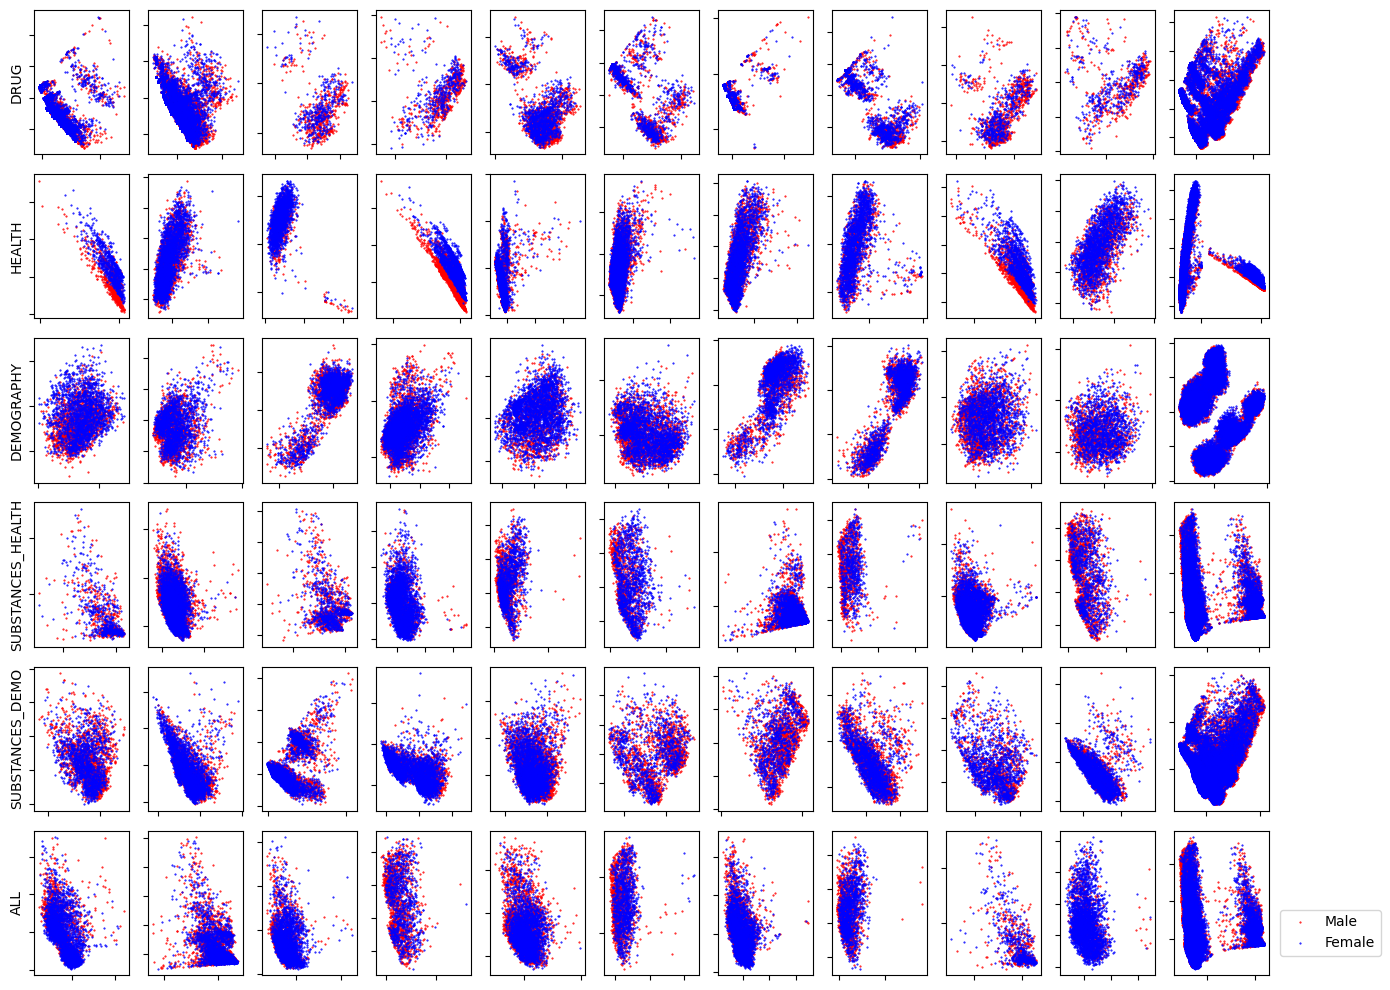

In [10]:
# ---------------------- DATA TYPE/CLUSTER ----------------------
models = [
    {
        'name': 'DRUG',
        'function': PCA(n_components=8),
        'train': profile_subs
    },
    {
        'name': 'HEALTH',
        'function': PCA(n_components=8),
        'train': profile_hlth
    },
    {
        'name': 'DEMOGRAPHY',
        'function': PCA(n_components=8),
        'train': profile_demo
    },
    {
        'name': 'SUBSTANCES_HEALTH',
        'function': PCA(n_components=8),
        'train': profile_subs_hlth
    },
    {
        'name': 'SUBSTANCES_DEMO',
        'function': PCA(n_components=8),
        'train': profile_subs_demo
    },
    {
        'name': 'ALL',
        'function': PCA(n_components=8),
        'train': profile_train
    }
]

dataset_labels = ['DRUG', 'HEALTH', 'DEMOGRAPHY', 'SUBSTANCES_HEALTH', 'SUBSTANCES_DEMO', 'ALL']

grid = 6
fig2 = plt.figure(figsize=(14, 10))

for n_idx, n in enumerate(models):
    print('\n ----------GRAPH GENERATION ' + n['name'] + '----------')
    
    model = n['function']
    train = n['train']
    print(train.shape)
    
    model.fit(train.values)
    train_transformed = model.transform(train.values)
    
    targets = [1, 2]
    colors = ['r.', 'b.']
    kmeans = KMeans(n_clusters=10).fit(train_transformed)
    pred_target = kmeans.predict(train_transformed)
    
    # Plot clusters (changed from 12 to 11)
    for cluster_num in range(10):
        plt3 = fig2.add_subplot(grid, 11, 1 + 11 * n_idx + cluster_num)  # Changed from 12 to 11
        for target, color in zip(targets, colors):
            target_idx = (pred_target == cluster_num)
            target_idx2 = all_train['IRSEX'] == target
            idx = target_idx & target_idx2
            plt3.plot(train_transformed[idx, 0], train_transformed[idx, 1], color, markersize=1)
            
        if cluster_num == 0:
            plt3.set_ylabel(dataset_labels[n_idx], fontsize=10)
          
        plt.setp(plt3.get_xticklabels(), visible=False)
        plt.setp(plt3.get_yticklabels(), visible=False)
    
    # Plot gender distribution (changed from 12 to 11)
    plt1 = fig2.add_subplot(grid, 11, 11 + 11 * n_idx)  # Changed from 12 to 11
    for target, color in zip(targets, colors):
        target_idx2 = all_train['IRSEX'] == target
        plt1.plot(train_transformed[target_idx2, 0], train_transformed[target_idx2, 1], 
                 color, markersize=1, label='Male' if target==1 else 'Female')
    
    # Add legend only to the last row
    if n_idx == len(models)-1:
        plt1.legend(bbox_to_anchor=(1.05, 0.5))
        
    plt.setp(plt1.get_xticklabels(), visible=False)
    plt.setp(plt1.get_yticklabels(), visible=False)

    '''
    plt1 = fig2.add_subplot(grid, 12, 12 + 12 * n_idx)
    plt.setp(plt1.get_xticklabels(), visible=False)
    plt.setp(plt1.get_yticklabels(), visible=False)
    plt.legend()
    '''
    latent_users = model.components_
    for user_num in range(8):
        print('\n -----USER ' + str(user_num) + '-----')

        # what features affects the most
        lu = latent_users[user_num, :]
        # print("Latent user shape:", latent_users.shape)
        up = train_transformed[:, user_num]
        # print("User proportions from latent user shape:", up.shape)
        lu_indices = np.where(lu > np.percentile(lu, 99))[0]
        print(lu_indices)
        top_lu_df = pd.DataFrame({'Feature': train.columns.values[lu_indices],
                                   'Latent User Pseudocount': lu[lu_indices]})
        top_lu_df.sort_values('Latent User Pseudocount', inplace=True, ascending=False)
        # print(top_lu_df.head(n=5))

        # what users are highest in component
        tmp_profile_df = train.copy()
        tmp_profile_df.insert(0, "User Proportion from Latent User", up)
        tmp_profile_df.sort_values('User Proportion from Latent User', inplace=True, ascending=False)
        # print(tmp_profile_df.head())
        # train.loc[44412, 'ALCYFU']

    n['train_LL'] = model.score(train.values)
    print("Train - Log-likelihood: ", n['train_LL'])
    n['train_ALL'] = model.score(train.values) / train.shape[0]  # not working when num_samp < num_feature
    print("Train - Average Log-Likelihood: ", n['train_ALL'])
    train_origin = model.inverse_transform(train_transformed)
    n['train_RE'] = ((train.values - train_origin) ** 2).mean()
    print("Train - Reconstruction Error: ", n['train_RE'])

    centroids = kmeans.cluster_centers_
    print("Train - Average Log-Likelihood with Kmeans: ", kmeans.score(train_transformed) / train.shape[0])
    print("Train - sum of squared distance: ", kmeans.inertia_)
    cluster_labels = kmeans.predict(train_transformed)
    print("Train - silhouette: ", silhouette_score(train_transformed, cluster_labels))

    for target, color in zip(targets, colors):
        print(target)
        target_idx = all_train['IRSEX'] == target
        cluster_labels = kmeans.predict(train_transformed[target_idx, :])
        print("Train - silhouette: ", silhouette_score(train_transformed[target_idx, :], cluster_labels))

out_data = "./UP.png"
fig2.tight_layout()
fig2.savefig(out_data, bbox_inches='tight')


----- Analysis for ALL Dataset -----
Explained variance ratio: [0.26760993 0.06434847 0.02985698 0.02567611 0.02385768 0.02155303
 0.01962245 0.0165053 ]
Cumulative explained variance: [0.26760993 0.3319584  0.36181538 0.38749149 0.41134917 0.43290219
 0.45252464 0.46902994]


/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Train Silhouette Score: 0.327
Test Silhouette Score: 0.330
Train Average Log-Likelihood: -17.271
Test Average Log-Likelihood: -17.402


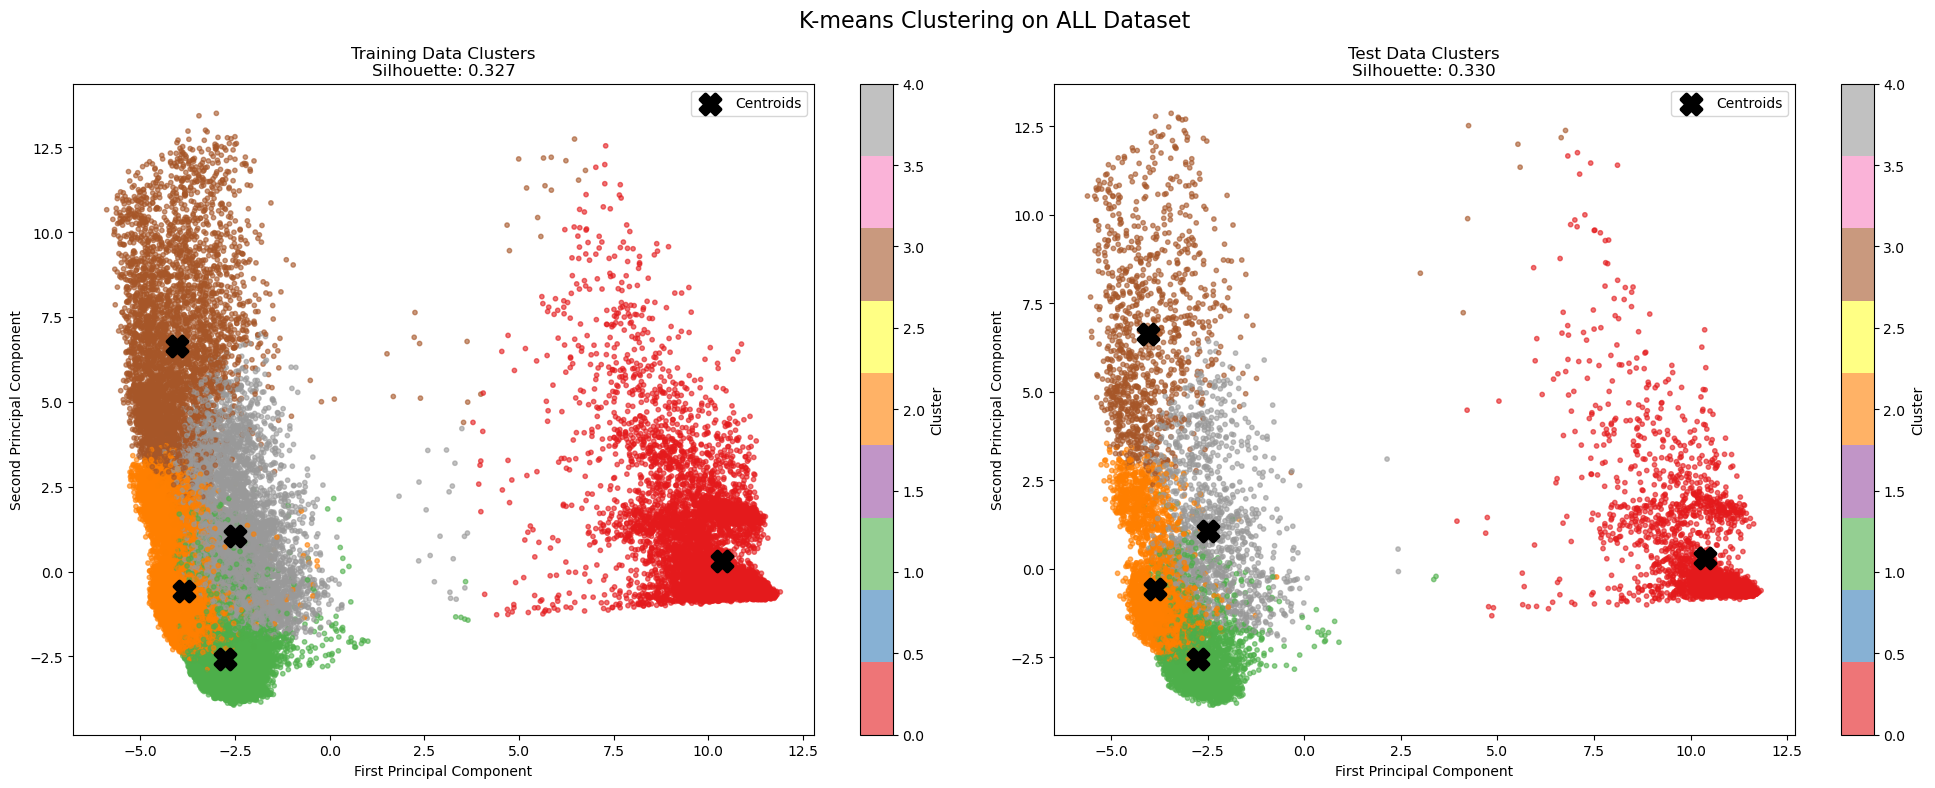


Cluster Characteristics:

Cluster 0:
PCA components: [10.36522931  0.3086342  -0.32918759 -0.05851256 -0.08214237 -0.11492823
 -0.05073151  0.05744852]
Train samples in cluster: 10840 (24.1%)
Test samples in cluster: 2820 (25.1%)
Most important PCA components: PC1, PC3, PC2

Cluster 1:
PCA components: [-2.76056428 -2.56816235  0.93821175 -0.45937952 -0.8109668   1.15698297
  0.05823938 -0.36788107]
Train samples in cluster: 11561 (25.7%)
Test samples in cluster: 2884 (25.6%)
Most important PCA components: PC1, PC2, PC6

Cluster 2:
PCA components: [-3.85698474 -0.56980159 -1.35723689  0.2865852  -0.00458892 -1.17442625
 -0.26629737  0.54023863]
Train samples in cluster: 12853 (28.5%)
Test samples in cluster: 3166 (28.1%)
Most important PCA components: PC1, PC3, PC6

Cluster 3:
PCA components: [-4.04452462  6.63115317  0.17709068 -0.23387337 -1.40019032  0.64800621
 -0.02320057 -0.47597749]
Train samples in cluster: 4208 (9.3%)
Test samples in cluster: 1070 (9.5%)
Most important PCA com

/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Train Silhouette Score: 0.450
Test Silhouette Score: 0.448
Train Average Log-Likelihood: -8.847
Test Average Log-Likelihood: -8.839


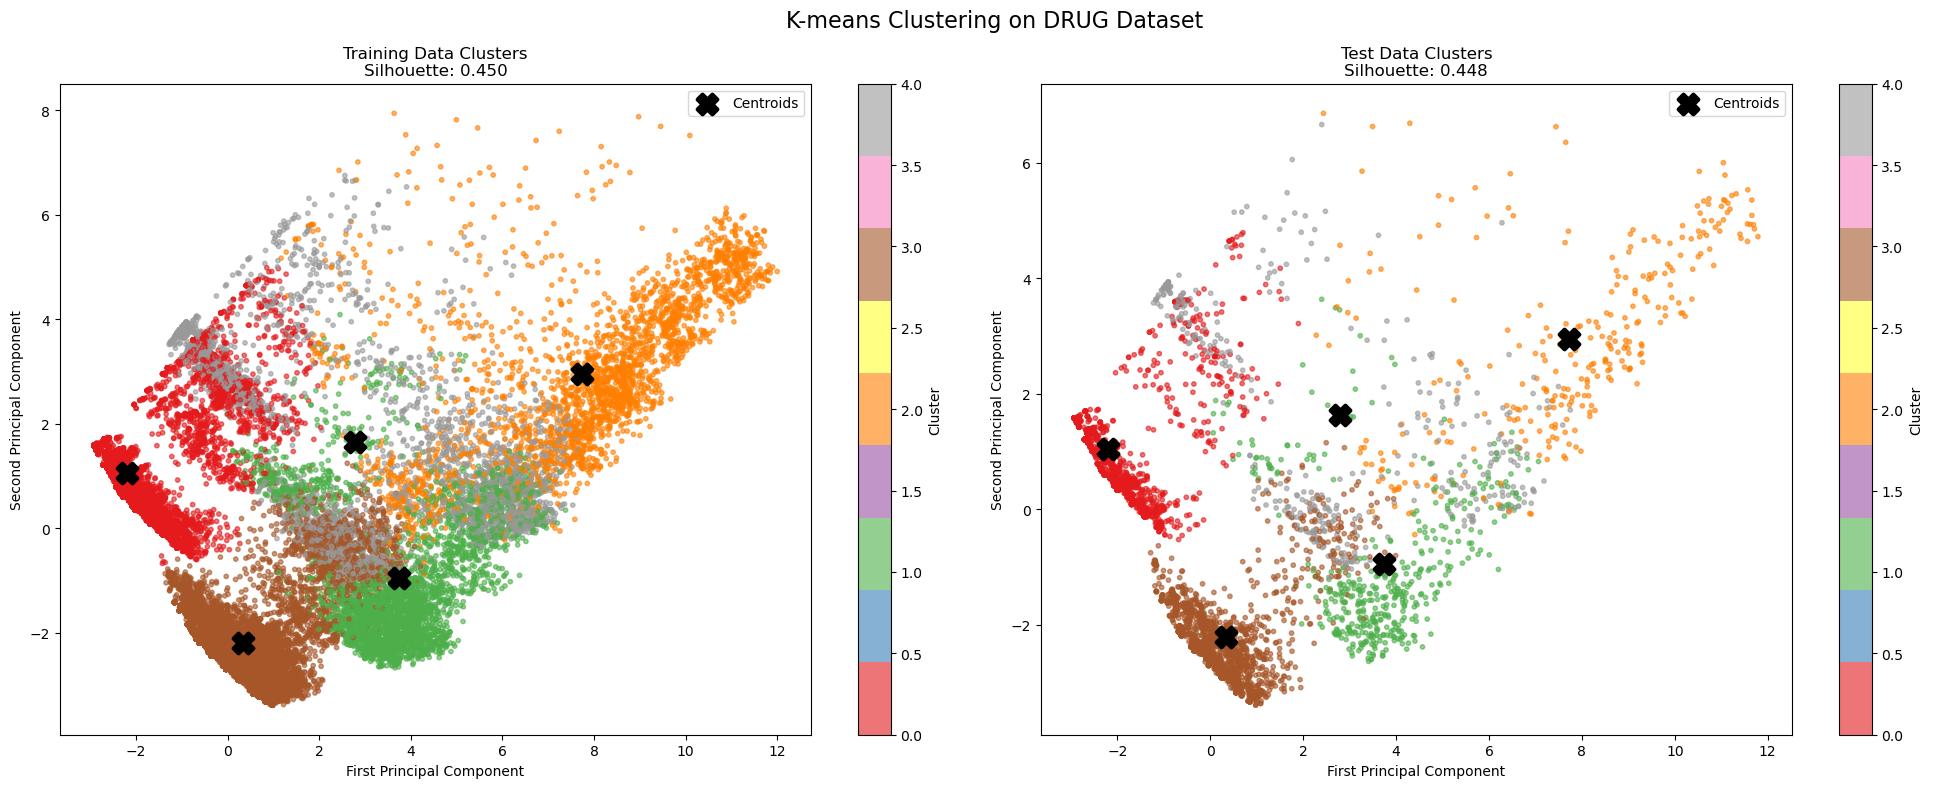


Cluster Characteristics:

Cluster 0:
PCA components: [-2.19136535  1.0541527   0.21429687 -0.30173416 -0.0034183   0.17562228
 -0.11178605  0.02563481]
Train samples in cluster: 21260 (47.2%)
Test samples in cluster: 2703 (48.0%)
Most important PCA components: PC1, PC2, PC4

Cluster 1:
PCA components: [ 3.74402879 -0.95094857  0.1043514  -3.32065316 -0.95708109 -0.05616423
 -0.21169457  0.09865777]
Train samples in cluster: 3539 (7.9%)
Test samples in cluster: 450 (8.0%)
Most important PCA components: PC1, PC4, PC5

Cluster 2:
PCA components: [ 7.73020676  2.95656385  1.61116027  0.4842485   1.02556903 -0.1644063
  0.45432814  0.08710366]
Train samples in cluster: 2537 (5.6%)
Test samples in cluster: 304 (5.4%)
Most important PCA components: PC1, PC2, PC3

Cluster 3:
PCA components: [ 0.32948807 -2.20278242  0.30691122  0.78182768  0.13152145 -0.23622473
  0.16605217 -0.06748073]
Train samples in cluster: 14455 (32.1%)
Test samples in cluster: 1777 (31.6%)
Most important PCA component

/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Train Silhouette Score: 0.314
Test Silhouette Score: 0.316
Train Average Log-Likelihood: -5.772
Test Average Log-Likelihood: -5.734


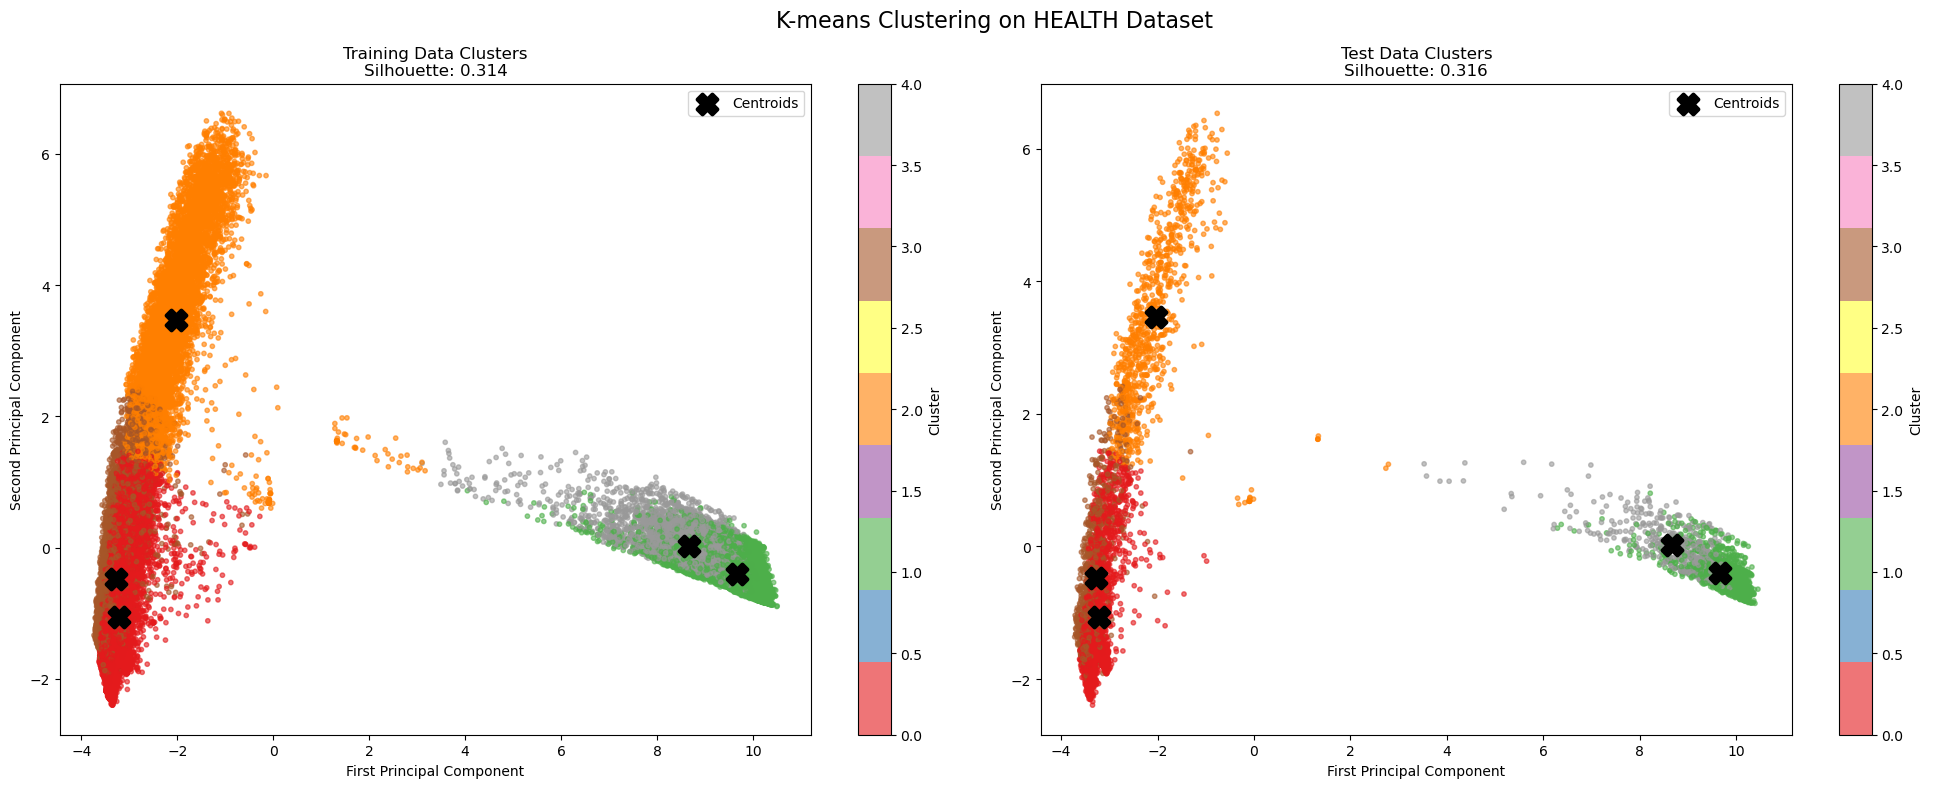


Cluster Characteristics:

Cluster 0:
PCA components: [-3.20874115 -1.0606189  -0.74677528 -0.12203485  0.10409217  0.03526841
 -0.03074348 -0.01476296]
Train samples in cluster: 18559 (41.2%)
Test samples in cluster: 2306 (41.0%)
Most important PCA components: PC1, PC2, PC3

Cluster 1:
PCA components: [ 9.66184685 -0.40032078 -0.02020856  0.01302402 -0.61861504  0.37181136
 -0.78356899  0.09409568]
Train samples in cluster: 7363 (16.4%)
Test samples in cluster: 962 (17.1%)
Most important PCA components: PC1, PC7, PC5

Cluster 2:
PCA components: [-2.03234101  3.46819713 -0.3726001   0.22018166 -0.10189038  0.06989573
 -0.00541255  0.11645558]
Train samples in cluster: 7593 (16.9%)
Test samples in cluster: 903 (16.0%)
Most important PCA components: PC2, PC1, PC3

Cluster 3:
PCA components: [-3.27820081e+00 -4.80484246e-01  2.02037505e+00  1.32621749e-01
 -1.86526308e-01 -6.79377950e-02  3.20811126e-03 -5.45529245e-02]
Train samples in cluster: 8023 (17.8%)
Test samples in cluster: 1003 

/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Train Silhouette Score: 0.353
Test Silhouette Score: 0.357
Train Average Log-Likelihood: -6.377
Test Average Log-Likelihood: -6.340


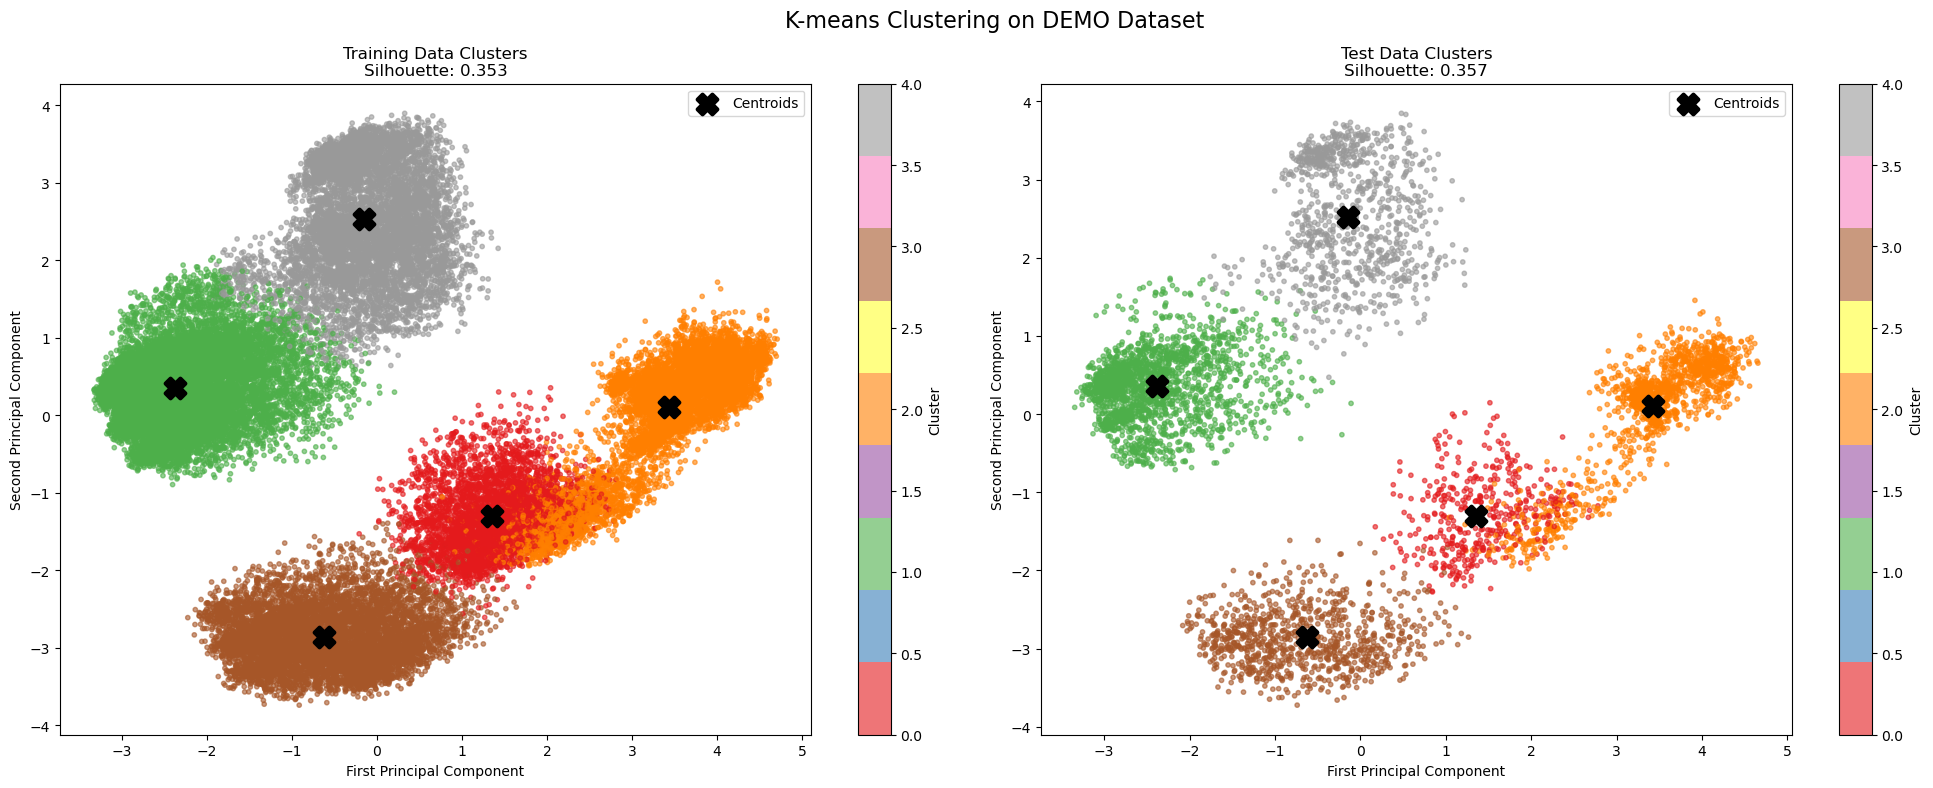


Cluster Characteristics:

Cluster 0:
PCA components: [ 1.34994658 -1.30507369  2.41287014 -1.36473593 -0.95959122 -0.10727979
 -0.11393064 -0.44087373]
Train samples in cluster: 3718 (8.3%)
Test samples in cluster: 425 (7.6%)
Most important PCA components: PC3, PC4, PC1

Cluster 1:
PCA components: [-2.37685918  0.35387916 -0.74996874  0.6291102  -0.00404867  0.07654384
  0.04151386 -0.00832821]
Train samples in cluster: 15424 (34.3%)
Test samples in cluster: 1914 (34.0%)
Most important PCA components: PC1, PC3, PC4

Cluster 2:
PCA components: [ 3.42970922  0.10786436 -1.39986151  0.39447283  0.13339308 -0.0692678
  0.02755915  0.04968522]
Train samples in cluster: 10889 (24.2%)
Test samples in cluster: 1422 (25.3%)
Most important PCA components: PC1, PC3, PC4

Cluster 3:
PCA components: [-0.62467828 -2.85689128  0.88482415 -0.37733265  0.47274527 -0.16210865
 -0.15712649  0.06917999]
Train samples in cluster: 7364 (16.4%)
Test samples in cluster: 921 (16.4%)
Most important PCA compone

In [12]:
# Define all datasets to analyze
datasets = [
    {'name': 'ALL', 'train': train, 'test': test},
    {'name': 'DRUG', 'train': subs_train, 'test': subs_test},
    {'name': 'HEALTH', 'train': hlth_train, 'test': hlth_test},
    {'name': 'DEMO', 'train': demo_train, 'test': demo_test}
]

for dataset in datasets:
    print(f"\n----- Analysis for {dataset['name']} Dataset -----")
    
    # Apply PCA
    pca = PCA(n_components=8)
    pca.fit(dataset['train'].values)
    
    # Transform both train and test data
    train_transformed = pca.transform(dataset['train'].values)
    test_transformed = pca.transform(dataset['test'].values)
    
    # Calculate explained variance
    explained_var = pca.explained_variance_ratio_
    print(f"Explained variance ratio: {explained_var}")
    print(f"Cumulative explained variance: {np.cumsum(explained_var)}")
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(train_transformed)
    
    # Get cluster predictions for both train and test
    train_labels = kmeans.labels_
    test_labels = kmeans.predict(test_transformed)
    
    # Calculate metrics for both train and test
    train_silhouette = silhouette_score(train_transformed, train_labels)
    test_silhouette = silhouette_score(test_transformed, test_labels)
    train_score = kmeans.score(train_transformed) / dataset['train'].shape[0]
    test_score = kmeans.score(test_transformed) / dataset['test'].shape[0]
    
    print(f"Train Silhouette Score: {train_silhouette:.3f}")
    print(f"Test Silhouette Score: {test_silhouette:.3f}")
    print(f"Train Average Log-Likelihood: {train_score:.3f}")
    print(f"Test Average Log-Likelihood: {test_score:.3f}")
    
    # Create subplot for train and test
    plt.figure(figsize=(20, 8))
    
    # Plot training data
    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(
        train_transformed[:, 0],
        train_transformed[:, 1],
        c=train_labels,
        cmap='Set1',
        alpha=0.6,
        s=10
    )
    plt.scatter(
        kmeans.cluster_centers_[:, 0],
        kmeans.cluster_centers_[:, 1],
        marker='X',
        s=200,
        linewidths=3,
        color='k',
        label='Centroids'
    )
    plt.title(f'Training Data Clusters\nSilhouette: {train_silhouette:.3f}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()
    plt.colorbar(scatter1, label='Cluster')
    
    # Plot test data
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(
        test_transformed[:, 0],
        test_transformed[:, 1],
        c=test_labels,
        cmap='Set1',
        alpha=0.6,
        s=10
    )
    plt.scatter(
        kmeans.cluster_centers_[:, 0],
        kmeans.cluster_centers_[:, 1],
        marker='X',
        s=200,
        linewidths=3,
        color='k',
        label='Centroids'
    )
    plt.title(f'Test Data Clusters\nSilhouette: {test_silhouette:.3f}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()
    plt.colorbar(scatter2, label='Cluster')
    
    plt.suptitle(f'K-means Clustering on {dataset["name"]} Dataset', fontsize=16)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'KMeans_Cluster_{dataset["name"]}_Train_Test.png')
    
    # Display the plot
    plt.show()
    
    # Close the figure to free memory
    plt.close()
    
    # Analyze cluster characteristics
    print("\nCluster Characteristics:")
    for i, centroid in enumerate(kmeans.cluster_centers_):
        print(f"\nCluster {i}:")
        print("PCA components:", centroid)
        
        # Calculate cluster sizes for both train and test
        train_size = np.sum(train_labels == i)
        test_size = np.sum(test_labels == i)
        print(f"Train samples in cluster: {train_size} ({train_size/len(train_labels)*100:.1f}%)")
        print(f"Test samples in cluster: {test_size} ({test_size/len(test_labels)*100:.1f}%)")
        
        # Get top features for the most significant PCA components
        top_pc_indices = np.argsort(-np.abs(centroid))[:3]
        print(f"Most important PCA components: PC{top_pc_indices[0]+1}, PC{top_pc_indices[1]+1}, PC{top_pc_indices[2]+1}")

In [13]:
# Define all datasets to analyze
datasets = [
    {'name': 'ALL', 'train': train, 'test': test},
    {'name': 'DRUG', 'train': subs_train, 'test': subs_test},
    {'name': 'HEALTH', 'train': hlth_train, 'test': hlth_test},
    {'name': 'DEMO', 'train': demo_train, 'test': demo_test}
]

for dataset in datasets:
    print(f"\n{'='*50}")
    print(f"Analysis for {dataset['name']} Dataset")
    print(f"{'='*50}")
    
    # Apply PCA
    pca = PCA(n_components=8)
    pca.fit(dataset['train'].values)
    
    # Get feature names
    feature_names = dataset['train'].columns
    
    # Create DataFrame of PCA loadings
    pca_loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(8)],
        index=feature_names
    )
    
    # Print explained variance for each component
    print("\nExplained Variance Ratio:")
    for i, var in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")
    print(f"Cumulative: {np.sum(pca.explained_variance_ratio_):.4f} ({np.sum(pca.explained_variance_ratio_)*100:.2f}%)")
    
    # Print top contributing features for each PC
    print("\nTop 10 Contributing Features for each Principal Component:")
    for pc in range(8):
        print(f"\nPC{pc+1} Top Features:")
        top_features = pca_loadings[f'PC{pc+1}'].abs().sort_values(ascending=False).head(10)
        print(top_features)
        print(f"Total features contributing to PC{pc+1}: {np.sum(pca_loadings[f'PC{pc+1}'].abs() > 0.1)}")

    print("\n" + "-"*80 + "\n")


Analysis for ALL Dataset

Explained Variance Ratio:
PC1: 0.2676 (26.76%)
PC2: 0.0643 (6.43%)
PC3: 0.0299 (2.99%)
PC4: 0.0257 (2.57%)
PC5: 0.0239 (2.39%)
PC6: 0.0216 (2.16%)
PC7: 0.0196 (1.96%)
PC8: 0.0165 (1.65%)
Cumulative: 0.4690 (46.90%)

Top 10 Contributing Features for each Principal Component:

PC1 Top Features:
IMOTHER_4       0.071412
CATAGE_1        0.071412
CATAG3_1        0.071412
EDUHIGHCAT_5    0.071412
CATAG2_1        0.071412
CATAG6_1        0.071412
IFATHER_4       0.071412
YSPTXNMH_0.0    0.071355
YMHASPTX_0.0    0.071272
MHLDTMT3_0.0    0.071187
Name: PC1, dtype: float64
Total features contributing to PC1: 0

PC2 Top Features:
MJREC_91        0.089483
MJEVER_2        0.089483
MJYFU_9991      0.089483
MJEVER_1        0.089416
KETMINESK_91    0.089150
HALLUCOTH_91    0.089150
HALLUC30E_91    0.089150
PCP_91          0.089150
PEYOTE_91       0.089150
HALLUCEVR_91    0.089150
Name: PC2, dtype: float64
Total features contributing to PC2: 0

PC3 Top Features:
CATAG6_2     


Variance Analysis for ALL Dataset

Variance Explained by Components:
PC1: 0.2676 (26.76%)
Cumulative: 0.2676 (26.76%)
PC2: 0.0643 (6.43%)
Cumulative: 0.3320 (33.20%)
PC3: 0.0299 (2.99%)
Cumulative: 0.3618 (36.18%)
PC4: 0.0257 (2.57%)
Cumulative: 0.3875 (38.75%)
PC5: 0.0239 (2.39%)
Cumulative: 0.4113 (41.13%)
PC6: 0.0216 (2.16%)
Cumulative: 0.4329 (43.29%)
PC7: 0.0196 (1.96%)
Cumulative: 0.4525 (45.25%)
PC8: 0.0165 (1.65%)
Cumulative: 0.4690 (46.90%)
PC9: 0.0151 (1.51%)
Cumulative: 0.4842 (48.42%)
PC10: 0.0116 (1.16%)
Cumulative: 0.4957 (49.57%)

Components needed for 70.0% variance: 49

Components needed for 80.0% variance: 102

Components needed for 90.0% variance: 216

Components needed for 95.0% variance: 329


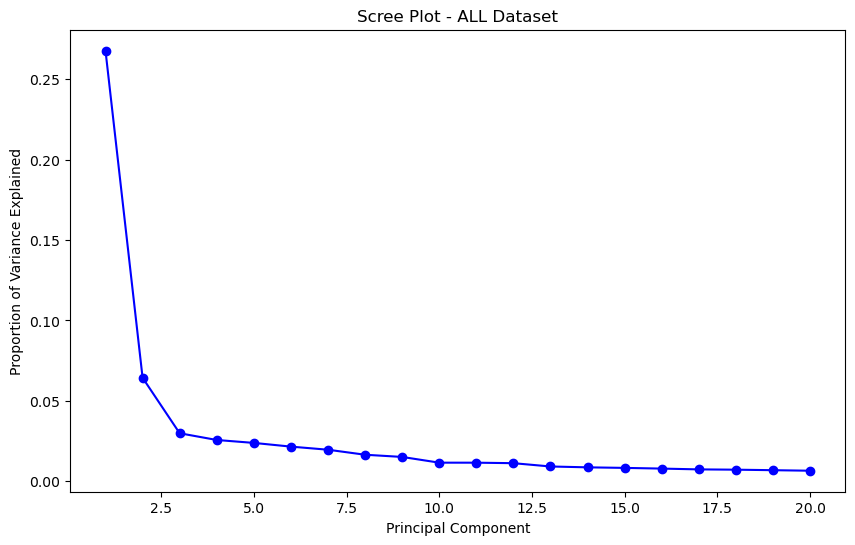


Variance Analysis for DRUG Dataset

Variance Explained by Components:
PC1: 0.2562 (25.62%)
Cumulative: 0.2562 (25.62%)
PC2: 0.1089 (10.89%)
Cumulative: 0.3651 (36.51%)
PC3: 0.0762 (7.62%)
Cumulative: 0.4413 (44.13%)
PC4: 0.0638 (6.38%)
Cumulative: 0.5051 (50.51%)
PC5: 0.0449 (4.49%)
Cumulative: 0.5500 (55.00%)
PC6: 0.0343 (3.43%)
Cumulative: 0.5843 (58.43%)
PC7: 0.0307 (3.07%)
Cumulative: 0.6150 (61.50%)
PC8: 0.0274 (2.74%)
Cumulative: 0.6424 (64.24%)
PC9: 0.0257 (2.57%)
Cumulative: 0.6680 (66.80%)
PC10: 0.0214 (2.14%)
Cumulative: 0.6894 (68.94%)

Components needed for 70.0% variance: 11

Components needed for 80.0% variance: 18

Components needed for 90.0% variance: 34

Components needed for 95.0% variance: 62


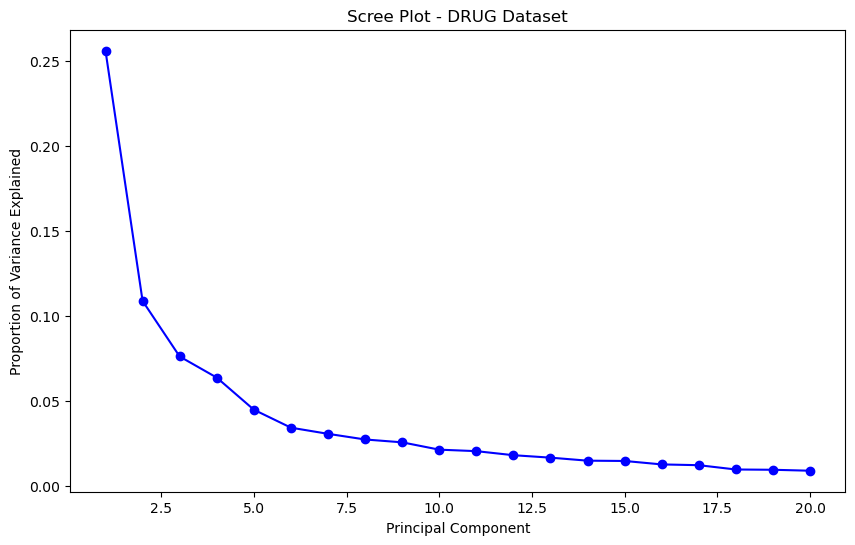


Variance Analysis for HEALTH Dataset

Variance Explained by Components:
PC1: 0.4540 (45.40%)
Cumulative: 0.4540 (45.40%)
PC2: 0.0545 (5.45%)
Cumulative: 0.5084 (50.84%)
PC3: 0.0261 (2.61%)
Cumulative: 0.5346 (53.46%)
PC4: 0.0187 (1.87%)
Cumulative: 0.5533 (55.33%)
PC5: 0.0164 (1.64%)
Cumulative: 0.5696 (56.96%)
PC6: 0.0154 (1.54%)
Cumulative: 0.5850 (58.50%)
PC7: 0.0147 (1.47%)
Cumulative: 0.5997 (59.97%)
PC8: 0.0121 (1.21%)
Cumulative: 0.6118 (61.18%)
PC9: 0.0110 (1.10%)
Cumulative: 0.6229 (62.29%)
PC10: 0.0091 (0.91%)
Cumulative: 0.6320 (63.20%)

Components needed for 70.0% variance: 21

Components needed for 80.0% variance: 56

Components needed for 90.0% variance: 122

Components needed for 95.0% variance: 183


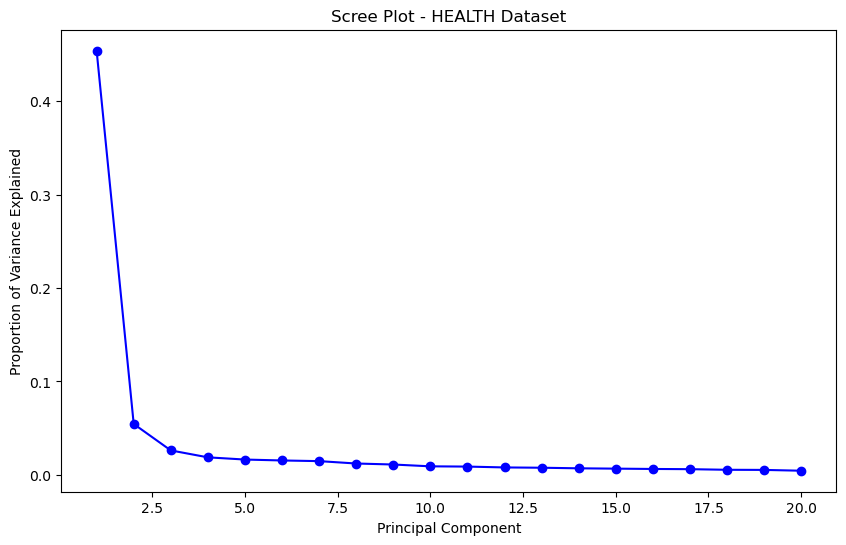


Variance Analysis for DEMO Dataset

Variance Explained by Components:
PC1: 0.1552 (15.52%)
Cumulative: 0.1552 (15.52%)
PC2: 0.0841 (8.41%)
Cumulative: 0.2393 (23.93%)
PC3: 0.0777 (7.77%)
Cumulative: 0.3170 (31.70%)
PC4: 0.0510 (5.10%)
Cumulative: 0.3680 (36.80%)
PC5: 0.0296 (2.96%)
Cumulative: 0.3977 (39.77%)
PC6: 0.0281 (2.81%)
Cumulative: 0.4258 (42.58%)
PC7: 0.0239 (2.39%)
Cumulative: 0.4496 (44.96%)
PC8: 0.0208 (2.08%)
Cumulative: 0.4704 (47.04%)
PC9: 0.0196 (1.96%)
Cumulative: 0.4900 (49.00%)
PC10: 0.0192 (1.92%)
Cumulative: 0.5092 (50.92%)

Components needed for 70.0% variance: 26

Components needed for 80.0% variance: 42

Components needed for 90.0% variance: 69

Components needed for 95.0% variance: 92


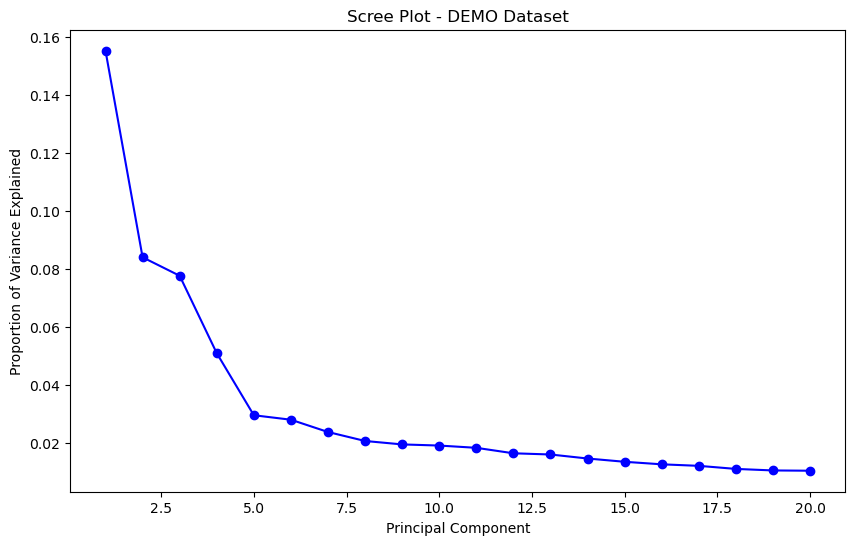

In [16]:
# Define all datasets to analyze
datasets = {
    'ALL': profile_train,
    'DRUG': profile_subs,
    'HEALTH': profile_hlth,
    'DEMO': profile_demo
}

for name, data in datasets.items():
    print(f"\n{'='*50}")
    print(f"Variance Analysis for {name} Dataset")
    print(f"{'='*50}")
    
    # Apply PCA
    pca = PCA()  # No fixed number of components
    pca.fit(data.values)
    
    # Calculate cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Print variance explained by each component
    print("\nVariance Explained by Components:")
    for i, var in enumerate(pca.explained_variance_ratio_[:10]):  # Show first 10 components
        print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")
        print(f"Cumulative: {cumulative_variance[i]:.4f} ({cumulative_variance[i]*100:.2f}%)")
    
    # Find number of components for different thresholds
    thresholds = [0.7, 0.8, 0.9, 0.95]
    for threshold in thresholds:
        n_components = np.argmax(cumulative_variance >= threshold) + 1
        print(f"\nComponents needed for {threshold*100}% variance: {n_components}")

    # Optional: Plot scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_[:20]) + 1), 
             pca.explained_variance_ratio_[:20], 'bo-')
    plt.title(f'Scree Plot - {name} Dataset')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.show()

In [17]:
#code to save the models

# Initialize dictionaries to store models
pca_models = {}
kmeans_models = {}

# Define all datasets to analyze
datasets = {
    'ALL': profile_train,
    'DRUG': profile_subs,
    'HEALTH': profile_hlth,
    'DEMO': profile_demo
}

for name, data in datasets.items():
    # Apply PCA with 8 components
    pca = PCA(n_components=8)
    pca.fit(data.values)
    
    # Store PCA model
    pca_models[name] = pca
    
    # Apply KMeans with 5 clusters
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(pca.transform(data.values))
    
    # Store KMeans model
    kmeans_models[name] = kmeans

# Create directory and save models
import os
os.makedirs('saved_models', exist_ok=True)

models_dict = {
    'pca_models': pca_models,
    'kmeans_models': kmeans_models
}

# Save models
with open('saved_models/pca_kmeans_models.pkl', 'wb') as f:
    pickle.dump(models_dict, f)

# Function to load models later
def load_models(filepath='saved_models/pca_kmeans_models.pkl'):
    with open(filepath, 'rb') as f:
        models = pickle.load(f)
    return models['pca_models'], models['kmeans_models']

/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saikrishnakathika/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

In [19]:
# Load models
pca_models, kmeans_models = load_models()

# Verify parameters
print("PCA components:", pca_models['ALL'].n_components_)  # Should be 8
print("KMeans clusters:", kmeans_models['ALL'].n_clusters)  # Should be 5

PCA components: 8
KMeans clusters: 5


In [21]:
# Load the saved models
pca_models, kmeans_models = load_models()

# For each dataset
datasets_names = ['ALL', 'DRUG', 'HEALTH', 'DEMO']
feature_sets = {
    'ALL': profile_train.columns,
    'DRUG': profile_subs.columns,
    'HEALTH': profile_hlth.columns,
    'DEMO': profile_demo.columns
}

for name in datasets_names:
    print(f"\n{'='*50}")
    print(f"Top Features in Principal Components for {name} Dataset")
    print(f"{'='*50}")
    
    pca = pca_models[name]
    features = feature_sets[name]
    
    # Get the absolute value of components
    components = np.abs(pca.components_)
    
    # For each PC (up to 8)
    for pc in range(8):
        # Get the indices of top 10 features
        top_indices = np.argsort(components[pc])[::-1][:10]
        
        print(f"\nPC{pc+1} Top Contributing Features:")
        for idx in top_indices:
            # Print feature name and its contribution
            contribution = components[pc][idx]
            print(f"{features[idx]}: {contribution:.4f}")
        print("-" * 30)


Top Features in Principal Components for ALL Dataset

PC1 Top Contributing Features:
EDUHIGHCAT_5: 0.0714
CATAG6_1: 0.0714
IMOTHER_4: 0.0714
IFATHER_4: 0.0714
CATAG2_1: 0.0714
CATAGE_1: 0.0714
CATAG3_1: 0.0714
YSPTXNMH_0.0: 0.0714
YMHASPTX_0.0: 0.0713
MHLDTMT3_0.0: 0.0712
------------------------------

PC2 Top Contributing Features:
MJEVER_2: 0.0895
MJYFU_9991: 0.0895
MJREC_91: 0.0895
MJEVER_1: 0.0894
KETMINESK_91: 0.0891
SALVIADIV_91: 0.0891
HALLUCEVR_91: 0.0891
HALLUC30E_91: 0.0891
HALLUCOTH_91: 0.0891
PCP_91: 0.0891
------------------------------

PC3 Top Contributing Features:
CATAG3_2: 0.1484
CATAG2_2: 0.1484
CATAG6_2: 0.1484
PREGAGE2_2: 0.1484
CATAGE_2: 0.1484
DRVINAGE_1: 0.1432
SEXAGE_5: 0.1285
DRVINDETAG_3: 0.1285
DRVINAGE_2: 0.1285
CATAG2_3: 0.1285
------------------------------

PC4 Top Contributing Features:
WRKHADJOB_2.0: 0.1565
WRKDPSTWK_1.0: 0.1544
WRKDPSTWK_2.0: 0.1483
IRWRKSTAT_4.0: 0.1432
WRKDRGPOL_1.0: 0.1379
WRKSELFEM_2.0: 0.1365
IRWRKSTAT18_4.0: 0.1358
WRKDPSTYR_2